**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**


# Goal of this notebook  
The goal of this notebook is to solve the McCall search model from [Ljungqvist and Sargent](https://www.sfu.ca/~kkasa/Recursive_Macroeconomic_Theory_Ljungqvist_Sargent_2018.pdf) Chapter 6.

1. For exposition, we assume the simplest possible distribution for wages:  
   $$
   w \sim \mathcal{U}[0, B]
   $$

2. For more complex wage distributions, we can use numerical integration methods as discussed in *"How to calculate the expectations of a neural network."*

---

## Set-up 

An unemployed agent receives a job offer $w_t$ in each period.

In this lecture, we consider the following simple environment:

* The sequence of offers $\{w_t\}_{t \geq 0}$ is i.i.d, with pdf $f(w)$   
* The agent observes $w_t$ at the beginning of period $t$.  
* The agent knows that $\{w_t\}$ is i.i.d with pdf $f(w)$ and can use this information when computing expectations.


At each time $t$, the agent has two options:

1. Accept the offer and work permanently at wage $w_t$.  
2. Reject the offer, receive unemployment compensation $c$, and reconsider next period.


The value function for this agent is

$$
v(w) = 
\underset{\text{Accept or Reject}}{\max} \biggl\{ \frac{w}{1-\beta}, c+ \beta \int_0^B v(w')f(w')dw'\biggr\}
$$


### Closed-form solution

This problem admits a closed-form solution in which the policy is a discrete choice:  

$$
u(w) = \begin{cases} 
\text{Reject} & \text{if } w < \bar{w} \\[2mm]
\text{Accept} & \text{if } w \geq \bar{w}
\end{cases}
$$  

where $\bar{w}$ is the **reservation wage**. The value function takes the form  

$$
v(w) =
\begin{cases} 
\frac{\bar{w}}{1-\beta} & \text{if } w < \bar{w} \\[2mm]
\frac{w}{1-\beta} & \text{if } w \geq \bar{w}
\end{cases}
$$  

where the reservation wage satisfies  

$$
\frac{\bar{w}}{1-\beta} \;=\; c + \beta \int_0^B v(w') f(w') \, dw'.  
$$  

Equivalently, $\bar{w}$ can be found by solving  

$$
\bar{w} - c = \frac{\beta}{1-\beta} \int_{\bar{w}}^B (w' - \bar{w}) f(w') \, dw'.  
$$  


For a detailed treatment and other solution methods, see the [McCall search model](https://python.quantecon.org/mccall_model.html) notes on the QuantEcon webpage.


In [1]:
# Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

# For closed-form solution
from scipy.integrate import quad
from scipy.optimize import fsolve

In [3]:
fontsize= 14
ticksize = 14
figsize = (6, 4)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

## Closed form solution

In [4]:
B = 0.5
c = 0.05
β = 0.9

In [5]:
## PDF of wages uniformly distributed on [0, B]
f = lambda w: 1/B if 0 <= w <= B else 0

In [6]:
def indifference(w):
    LHS = w-c
    integrand = lambda z: (z - w) * f(z)
    integral, error = quad(integrand, w, B)
    
    RHS = (β/(1-β))* integral
    return LHS-RHS

In [7]:
## finiding w_bar

In [8]:
w_bar = fsolve(indifference, x0=0.5)[0]

In [9]:
## closed-form value function 

In [10]:
def v_theory(w):
    reject_value = w_bar/(1-β)
    accept_value = w/(1-β)
    index = (w> w_bar)*1.0
    return (index*accept_value)+ ((1-index)*reject_value)

In [11]:
w_grid = np.linspace(0,B,1000)
v_theory_grid = v_theory(w_grid)

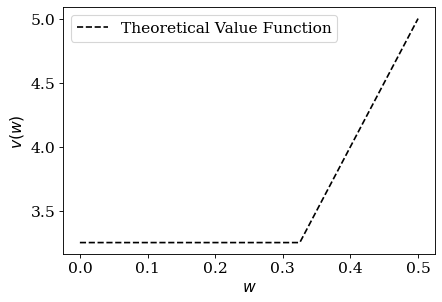

In [12]:
plt.plot(w_grid, v_theory_grid, '--', color = "k", label='Theoretical Value Function')
plt.xlabel('$w$')
plt.ylabel('$v(w)$')
plt.legend()
plt.show()

## Deep learning solution

In [13]:
# defining the neural network

In [14]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,
                layers = 2,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,1))
        #module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

In [15]:
# defining the training data and data-loader

In [16]:
steps = 0.02
w_grid_train = torch.linspace(0.0, B, steps=int(B/steps) + 1)
w_grid_train = w_grid_train.unsqueeze(dim =1)

data_loader = DataLoader(w_grid_train, batch_size=len(w_grid_train), shuffle= False)

In [17]:
num_epochs = 5001 # number of epochs

print_epoch_frequency = 1000 # how often printing the results

In [18]:
# initiating the neural network and setting up the optimizer

In [19]:
v_hat = NN()
learning_rate = 1e-2
optimizer = torch.optim.Adam(v_hat.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

### Calculating the expectation of the value function

I use the Gauss–Legendre quadrature method to evaluate the expectation integral.  
For more details on this method, see this [notebook](https://github.com/Mekahou/Notes/blob/main/expectation_and_numerical_integration/Gauss_Legendre_quadrature.ipynb).


In [20]:
def E_v(model,a,b,n):
    # model: the neural network (or any callable)
    # a: lower bound of the unifrom distribution
    # b: upper bound of the uniform distribution
    # n: number of the nodes Gauss-legendre quadrature
    nodes, weights = np.polynomial.legendre.leggauss(n)
    nodes_tensor = torch.tensor(nodes, dtype=torch.float32).unsqueeze(-1)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).unsqueeze(-1)
    adjusted_nodes = ((b - a) / 2) * nodes_tensor + ((a + b) / 2)
    integral = ((b - a) / 2) * torch.sum(weights_tensor * model(adjusted_nodes))
    expectation = integral/(b-a)
    return expectation

In [21]:
#testing
E_v(model = v_hat, a = 0, b = B, n = 3) 

tensor(0.0609, grad_fn=<DivBackward0>)

In [22]:
# training loop

In [23]:
for epoch in range(num_epochs):
    for w in data_loader:
        optimizer.zero_grad() # Resetting the gradients 
        lhs_v = v_hat(w)
        v_employed = w/(1-β)
        v_unemployed = c + β*E_v(model = v_hat, a = 0, b = B, n = 50)
        rhs_v = torch.max(v_employed, v_unemployed) 
        residual = lhs_v-rhs_v
        loss = (residual ** 2).mean()
        
        loss.backward() # Calculating the gradients (with respect to NN coefficients)
        optimizer.step() # Using the gradients to minimize the loss function
        
    scheduler.step() # Dampening the learning rate
    
    if epoch % print_epoch_frequency == 0:
        print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")

epoch = 0, loss = 8.16e+00
epoch = 1000, loss = 3.44e-05
epoch = 2000, loss = 2.82e-05
epoch = 3000, loss = 6.24e-06
epoch = 4000, loss = 2.09e-06
epoch = 5000, loss = 1.69e-06


## Plotting the results

In [24]:
w_grid_test = torch.arange(0.0, B , 0.002)
w_grid_test = w_grid_test.unsqueeze(dim =1)
v_theory_test = v_theory(w_grid_test)
v_hat_test = v_hat(w_grid_test).detach()

In [25]:
relative_error = (v_theory_test - v_hat_test)/v_theory_test
abs_rel_err = torch.abs(relative_error)

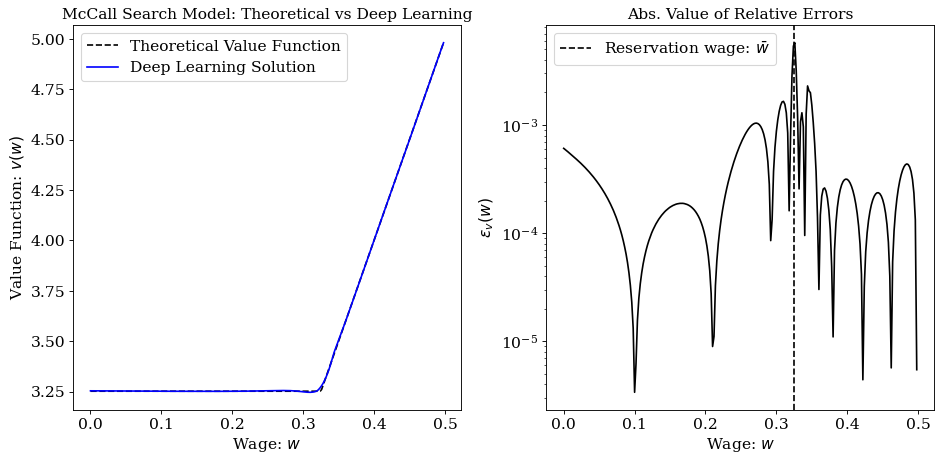

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# --- Left plot: value functions ---
axes[0].plot(w_grid_test, v_theory_test, '--', color="k", label="Theoretical Value Function")
axes[0].plot(w_grid_test, v_hat_test, color="b", label='Deep Learning Solution')
axes[0].set_xlabel('Wage: $w$')
axes[0].set_ylabel(r"Value Function: $v(w)$")
axes[0].set_title("McCall Search Model: Theoretical vs Deep Learning")
axes[0].legend()
plt.tight_layout()

# --- Right plot: absolute relative error ---
axes[1].plot(w_grid_test, abs_rel_err, color="k")
axes[1].set_xlabel('Wage: $w$')
axes[1].set_yscale("log")
axes[1].set_ylabel(r"$\varepsilon_v(w)$")
axes[1].set_title(r"Abs. Value of Relative Errors")
axes[1].axvline(x=w_bar, color="k", linestyle="--", label=r"Reservation wage: $\bar{w}$")
axes[1].legend()

plt.tight_layout()
plt.savefig("mccall_model.pdf")  # <-- Save as PDF
plt.show()

The absolute value of relative errors are defined as:

$$
\varepsilon_v(w) \equiv \bigl|\frac{\hat{v}(w)-v(w)}{v(w)}\bigr| 
$$